In [1]:
import math
from functools import reduce
import scipy.linalg as sla
import scipy.sparse as sp
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

**This homework was done in equal part by Zura Jashi and Marko Brnovic. Zura contributed to analytic calculations, Marko converted them to code.**

**Part a)**

We know that since $| \varphi \rangle$ is primary, we have $L_1| \varphi \rangle = \bar{L}_1| \varphi \rangle = L_2| \varphi \rangle = \bar{L}_2| \varphi \rangle = 0$. Therefore the $L_1, \bar{L}_1, L_2, \bar{L}_2$ terms in $O_1$, $O_2$ act trivially on $| \varphi \rangle$. With the definition $$\Gamma_{\varphi} = \sum_{\varphi_{\alpha}: E_{\alpha} < E_{\varphi}} | \varphi_{\alpha} \rangle \langle \varphi_{\alpha} |$$.

$$\implies \Gamma_{\varphi} O_n | \varphi \rangle = \frac{1}{2}\sum_{\varphi_{\alpha}: E_{\alpha} < E_{\varphi}} \left[| \varphi_{\alpha} \rangle \langle \varphi_{\alpha} | L_{-n} | \varphi_{\alpha} \rangle\right] + | \varphi_{\alpha} \rangle \langle \varphi_{\alpha} | \bar{L}_{-n} | \varphi_{\alpha} \rangle$$

If $| \varphi_{\alpha} \rangle$ is a primary operator, it corresponds to the lowest state in its tower. Then, we have to consider two cases:

1. $| \varphi_{\alpha} \rangle$ come from the same tower. But then, by definition, $\Gamma_{\varphi} = 0$, since there aren't any states with a lower energy than $| \varphi \rangle$. Therefore $\Gamma_{\varphi} = 0$ identically.

2. $| \varphi_{\alpha} \rangle$ come from a different tower. But then, $\langle \varphi_{\alpha} | L_{-n} | \varphi_{\alpha} \rangle = 0$, $\forall \varphi_{\alpha}$, since states from different towers are orthogonal and $L_{-1} | \varphi_{\alpha} \rangle$ only shifts $| \varphi_{\alpha} \rangle$ in the same tower. In both cases, we can see

\begin{equation}
  \boxed{\Gamma_{\varphi} O_n | \varphi \rangle = 0; \quad n = 1,2}
\end{equation}

Using definitions from tutorial 1 code for the rest of the homeworks. Credits to Mohamed Hibat Allah.

In [2]:
#
#	**********  BASIC MATRIX DEFINITIONS  **********
#

Sz = sp.dia_matrix([[1.0,0.0],[0.0,-1.0]])
Sx = sp.csc_matrix([[0.0,1.0],[1.0,0.0]])
Sy = sp.csc_matrix([[0.0,-1j],[1j,0.0]])

def Id(n): #defining the identity matrix
	return sp.eye(2**n)

def Szi(i,n): #defining the Sz operator at site i given n spins
	A = Id(i)
	B = Id(n-i-1)
	D = reduce(sp.kron, [A,Sz,B])
	return D

def Sxi(i,n): #defining the Sx operator at site i given n spins
	A = Id(i)
	B = Id(n-i-1)
	D = reduce(sp.kron, [A,Sx,B])
	return D

def interaction(c,i,j,n): #defining the SzSz operator at sites i, j given n spins
	if (i == j):
		print("i and j must be distinct!")
	elif (j<i):
		return interaction(c,j,i,n)
	else:
		A = Id(i)
		B = Id(j-i-1)
		C = Id(n-j-1)
		D = reduce(sp.kron, [A,Sz,B,Sz,C])
	return c*D


def NNterm(n): #defining the sum of SzSz terms
  #print 'Using Periodic BC'
  for i in range(n):
    if(i == 0):
      H = interaction(1,i,i+1,n)
    else:
      H = H + interaction(1,i,(i+1)%n,n)
  return H

def TrField(n): #defining the transverse magnetic field term
	for i in range(n):
		if (i == 0):
			F = Sxi(i,n)
		else:
			F = F + Sxi(i,n)
	return F

def sparse_diag(N,Bx,num):
	"""
	a function that provides the spare diagonalization of the 1D TFIM model given a system size N and the transverse field Bx
	returns: (ground state energy, first excited energy, gap)
	"""

	trfield = TrField(N)
	interterm = NNterm(N)

	H = -sp.csc_matrix(interterm + Bx*trfield) #sparce representation of the Hamiltonian

	eigenvalues = sp.linalg.eigsh(H, k = num,which='SA')[0]

	eigenvectors = sp.linalg.eigsh(H, k = num,which='SA')[1]
	return eigenvalues, eigenvectors
	#	Note: val[1] corresponds to the first excited state energy numerically. However you will observe that val[1] will be equal to val[0] at Bx = 0 which is a consequence of the Z2 summetry of the 1D TFIM.

Defining new Fourier modes:

In [3]:
def NNterm_(N, n): #redefining the sum of SzSz terms in terms of modes"
  #print 'Using Periodic BC'
  for i in range(N):
    if(i == 0):
      H = np.exp(1j * (i + 1/2) * n * 2 * np.pi / N) * interaction(1,i,i+1,N)
    else:
      H = H + np.exp(1j * (i + 1/2) * n * 2 * np.pi / N) * interaction(1,i,(i+1)%N,N)
  return H

def TrField_(N, n): #redefining the transverse magnetic field term in terms of modes
	for i in range(N):
		if (i == 0):
			F = np.exp(1j * i * n * 2 * np.pi / N) * Sxi(i,N)
		else:
			F = F + np.exp(1j * i * n * 2 * np.pi / N) * Sxi(i,N)
	return F

def H_n(N, n):

  #Fourier modes of H

	trfield = TrField_(N, n) * (-N / (2*np.pi))
	interterm = NNterm_(N, n) * (-N / (2*np.pi))

	return sp.csc_matrix(interterm + trfield) #sparse representation of the Hamiltonian

def O_n(N, n):

	return (H_n(N, n) + H_n(N, -n)) / 2

**Part b)**

In [4]:
N = 16 #system size
Bx = 1.0 #transverse magnetic field

eigva_16, eigve_16 = sparse_diag(N, Bx, 22)

In [5]:
O_1 = O_n(16, 1)

O_2 = O_n(16, 2)

In [6]:
def find_norm(eigenvectors, eigenvalues, O):

  norms = np.zeros_like(eigenvalues)

  for i in range(len(eigenvalues)):

    vec = np.zeros(len(eigenvectors[:, 0]), dtype = np.complex128)

    for j in range(i):

      vec += np.dot(eigenvectors[:, j], O.dot(eigenvectors[:, i])) * eigenvectors[:, j]

    norms[i] = np.linalg.norm(vec)

  return norms

In [7]:
norm_1 = find_norm(eigve_16, eigva_16, O_1)
norm_2 = find_norm(eigve_16, eigva_16, O_2)

In [8]:
norm_1 + norm_2

array([0.00000000e+00, 4.38538095e-15, 1.36424722e-13, 2.02382511e-01,
       4.56332291e-01, 1.30464558e+00, 3.39257317e-01, 6.27187034e-01,
       1.47477165e+00, 1.57157841e+00, 2.46761652e+00, 4.99197197e-01,
       2.61801895e+00, 3.31799676e+00, 2.62049112e+00, 3.21338372e+00,
       4.34979458e+00, 4.34979458e+00, 1.40514400e+00, 2.38318589e+00,
       1.37694715e+00, 1.93090687e+00])

Clearly the first three states are primary, the ones after have orders of magnitude higher norms

In [9]:
I = eigve_16[:, 0]
sigma = eigve_16[:, 1]
epsilon = eigve_16[:, 2]

**Part c)**

In [10]:
I2_ren = O_2.dot(I) / np.linalg.norm(O_2.dot(I))

$$\langle I^2_{\mathrm{ren}} | H^{\mathrm{CFT}} | I^2_{\mathrm{ren}} \rangle = \frac{2 \pi}{L} \left(\Delta^I_{2} - \frac{c}{12}\right) = \frac{2 \pi}{L} \left(2 - \frac{c}{12}\right)$$

$$\langle I | H^{\mathrm{CFT}} | I \rangle = \frac{2 \pi}{L} \left(\Delta^{I} - \frac{c}{12}\right) = -\frac{\pi c}{6 L}$$

$$ \langle H^{\mathrm{CFT}} \rangle_{I^2_{\mathrm{ren}}} - \langle H^{\mathrm{CFT}} \rangle_{I} = \frac{1}{a} \left[\langle H \rangle_{I^2_{\mathrm{ren}}} - E_I\right] = \frac{4\pi}{L}$$

$$\implies a = \frac{L}{4\pi}\left[\langle H \rangle_{I^2_{\mathrm{ren}}} - E_I\right]$$

In [11]:
H_16 = -sp.csc_matrix(NNterm(16) + Bx*TrField(16))
a = (np.dot(H_16.dot(I2_ren), I2_ren) - eigva_16[0]) * 16 / (4 * np.pi)

print(a)

(1.9776049177621247+0j)


Very close to 2.

Following the previous calculation, we can see

$$\langle H^{\mathrm{CFT}} \rangle_{\sigma} - \langle H^{\mathrm{CFT}} \rangle_{I} = \frac{E_{\sigma} - E_{I}}{a} = \frac{2\pi \Delta_{\sigma}}{L}$$

$$\implies \Delta_{\sigma} = \frac{L\left(E_{\sigma} - E_{I}\right)}{2\pi a}$$

Similarly,

$$\Delta_{\epsilon} = \frac{L\left(E_{\epsilon} - E_{I}\right)}{2\pi a}$$

In [12]:
delta_sigma = (eigva_16[1] - eigva_16[0])  * 16 / (2 * np.pi * a)
delta_epsilon = (eigva_16[2] - eigva_16[0])  * 16 / (2 * np.pi * a)

In [13]:
print(delta_sigma, delta_epsilon)

(0.1265171769606433+0j) (1.0097005565351749+0j)


Close enough!

**Part c)**

In [14]:
alpha = 2 - 2 / (2 - delta_epsilon)
beta = delta_sigma / (2 - delta_epsilon)
delta = (2 - delta_sigma) / delta_sigma
eta = 2*delta_sigma
nu = 1 / (2 - delta_epsilon)

In [15]:
print(alpha, beta, delta, eta, nu)

(-0.019591158208137394+0j) (0.12775648597558473+0j) (14.808130153126607+0j) (0.2530343539212866+0j) (1.0097955791040687+0j)


Close enough!

In [16]:
def critical_exponents(N_min, N_max):

  delta_sigmas = np.zeros(N_max - N_min + 1, dtype = np.complex128)
  delta_epsilons = np.zeros(N_max - N_min + 1, dtype = np.complex128)

  alphas = np.zeros(N_max - N_min + 1, dtype = np.complex128)
  betas = np.zeros(N_max - N_min + 1, dtype = np.complex128)
  deltas = np.zeros(N_max - N_min + 1, dtype = np.complex128)
  etas = np.zeros(N_max - N_min + 1, dtype = np.complex128)
  nus = np.zeros(N_max - N_min + 1, dtype = np.complex128)

  for i in range(N_min, N_max + 1):

    O_2 = O_n(i, 2)

    H = -sp.csc_matrix(NNterm(i) + Bx*TrField(i))

    eigenvalues, eigenvectors = sparse_diag(i, Bx, 3) #Only choosing the first three states (cheating)

    I2_ren = O_2.dot(eigenvectors[:, 0]) / np.linalg.norm(O_2.dot(eigenvectors[:, 0]))

    a = (np.dot(H.dot(I2_ren), I2_ren) - eigenvalues[0]) * i / (4 * np.pi)

    delta_sigmas[i - N_min] = (eigenvalues[1] - eigenvalues[0])  * i / (2 * np.pi * a)
    delta_epsilons[i - N_min] = (eigenvalues[2] - eigenvalues[0])  * i / (2 * np.pi * a)

    alphas[i - N_min] = 2 - 2 / (2 - delta_epsilons[i - N_min])
    betas[i - N_min] = delta_sigmas[i - N_min] / (2 - delta_epsilons[i - N_min])
    deltas[i - N_min] = (2 - delta_sigmas[i - N_min]) / delta_sigmas[i - N_min]
    etas[i - N_min] = 2*delta_sigmas[i - N_min]
    nus[i - N_min] = 1 / (2 - delta_epsilons[i - N_min])

  return delta_sigmas, delta_epsilons, alphas, betas, deltas, etas, nus

In [17]:
delta_sigmas, delta_epsilons, alphas, betas, deltas, etas, nus = critical_exponents(16, 20)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


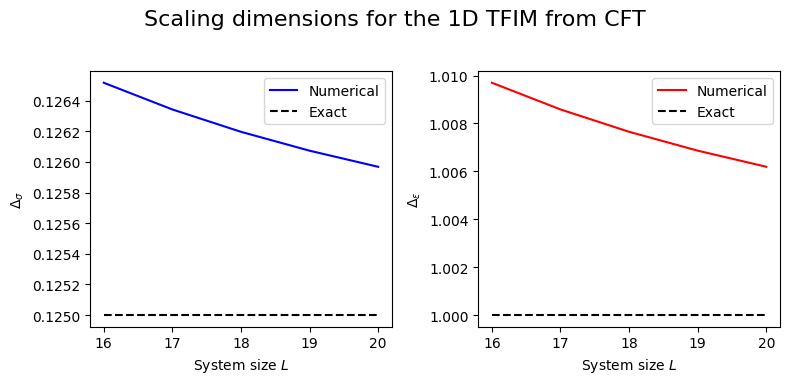

In [18]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex = True)
fig.suptitle('Scaling dimensions for the 1D TFIM from CFT', fontsize=16)

x = range(16, 21)

# Plot each array in its own subplot
axs[0].plot(x, delta_sigmas, color='blue', label = 'Numerical')
axs[0].set_xlabel('System size $L$')
axs[0].set_ylabel(r'$\Delta_{\sigma}$')
axs[1].plot(x, delta_epsilons, color='red', label = 'Numerical')
axs[1].set_xlabel('System size $L$')
axs[1].set_ylabel(r'$\Delta_{\epsilon}$')

axs[0].hlines(1/8, 16, 20, linestyle='--', color = 'black', label = 'Exact')
axs[1].hlines(1, 16, 20, linestyle='--', color = 'black', label = 'Exact')

axs[0].legend(loc = 'upper right')
axs[1].legend(loc = 'upper right')

# axs[0].set_ylim(1/8 - 5e-4, 0.13)
# axs[1].set_ylim(1 - 2.5e-3, 1 + 2e-2)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Clearly, they are getting closer to the values $\frac{1}{8}$ and 1 respectively.

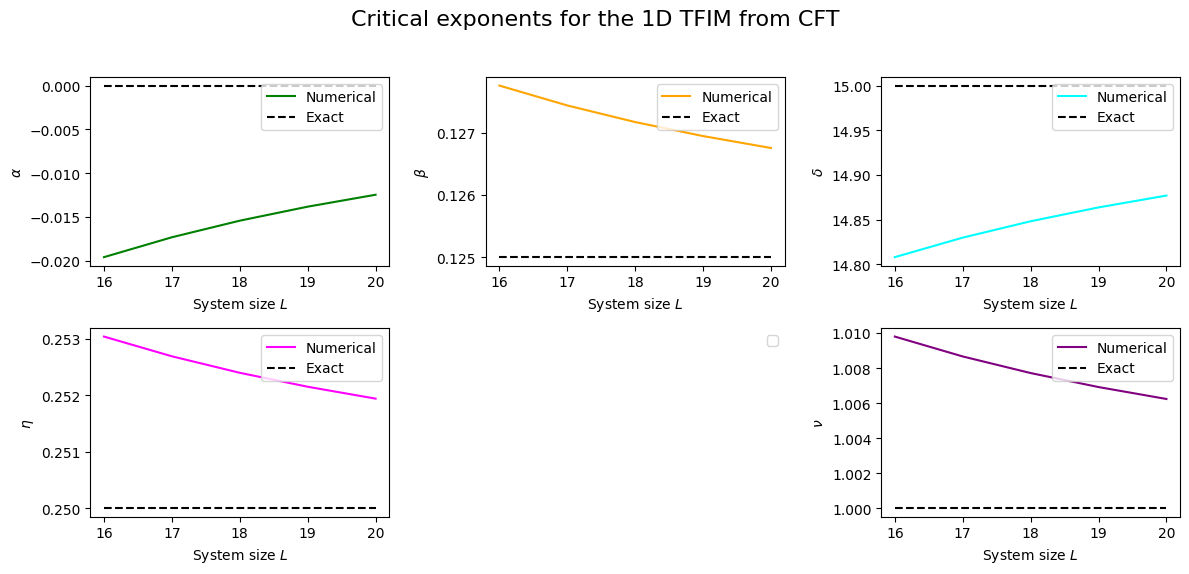

In [19]:
# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle('Critical exponents for the 1D TFIM from CFT', fontsize=16)

x = range(16, 21)

# Plot each array in its own subplot
axs[0, 0].plot(x, alphas, color='green', label='Numerical')
axs[0, 0].hlines(0, 16, 20, linestyle='--', color='black', label='Exact')
axs[0, 0].set_xlabel('System size $L$')
axs[0, 0].set_ylabel(r'$\alpha$')

axs[0, 1].plot(x, betas, color='orange', label='Numerical')
axs[0, 1].hlines(1/8, 16, 20, linestyle='--', color='black', label='Exact')
axs[0, 1].set_xlabel('System size $L$')
axs[0, 1].set_ylabel(r'$\beta$')

axs[0, 2].plot(x, deltas, color='cyan', label='Numerical')
axs[0, 2].hlines(15, 16, 20, linestyle='--', color='black', label='Exact')
axs[0, 2].set_xlabel('System size $L$')
axs[0, 2].set_ylabel(r'$\delta$')

axs[1, 0].plot(x, etas, color='magenta', label='Numerical')
axs[1, 0].hlines(1/4, 16, 20, linestyle='--', color='black', label='Exact')
axs[1, 0].set_xlabel('System size $L$')
axs[1, 0].set_ylabel(r'$\eta$')

axs[1, 2].plot(x, nus, color='purple', label='Numerical')
axs[1, 2].hlines(1, 16, 20, linestyle='--', color='black', label='Exact')
axs[1, 2].set_xlabel('System size $L$')
axs[1, 2].set_ylabel(r'$\nu$')

# Hide empty subplots
axs[1, 1].axis('off')

# Set legends
for ax in axs.flat:
    ax.legend(loc='upper right')

# Set y-axis limits for better visualization
# axs[0, 0].set_ylim(1.8, 6.2)
# axs[0, 1].set_ylim(1.8, 6.2)
# axs[1, 0].set_ylim(2.8, 7.2)
# axs[1, 1].set_ylim(2.8, 7.2)
# axs[2, 0].set_ylim(3.8, 8.2)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Clearly increasing system size brings us closer to the exact values.

In [20]:
def scaling_dim(O, state):

  ren_state = O.dot(state) / np.linalg.norm(O.dot(state))

  return np.dot(H_16.dot(ren_state), ren_state), (np.dot(H_16.dot(ren_state), ren_state) - eigva_16[0])  * 16 / (2 * np.pi * a)

**Part f)**

In [21]:
print('n = 1, I:', np.real(scaling_dim(O_1, I)[1]), 'finite size => large error')

print('n = 2, I:', np.real(scaling_dim(O_2, I)[1]), 'equal to 2')

print('n = 1, sigma:', np.real(scaling_dim(O_1, sigma)[1]), 'approximately equal to 1 + 1/8')

print('n = 2, sigma:', np.real(scaling_dim(O_2, sigma)[1]), 'approximately equal to 2 + 1/8')

print('n = 1, epsilon:', np.real(scaling_dim(O_1, epsilon)[1]), 'approximately equal to 1 + 1')

print('n = 1, epsilon:', np.real(scaling_dim(O_2, epsilon)[1]), 'approximately equal to 2 + 1')

n = 1, I: 2.281351901994459 finite size => large error
n = 2, I: 2.0 equal to 2
n = 1, sigma: 1.1313557493370219 approximately equal to 1 + 1/8
n = 2, sigma: 2.0975789388968678 approximately equal to 2 + 1/8
n = 1, epsilon: 2.0000000000000275 approximately equal to 1 + 1
n = 1, epsilon: 2.9328416781480624 approximately equal to 2 + 1


In [22]:
print(np.real(scaling_dim(O_1, I)[0]), np.real(scaling_dim(O_2, I)[0]), np.real(scaling_dim(O_1, sigma)[0]), np.real(scaling_dim(O_2, sigma)[0]), np.real(scaling_dim(O_1, epsilon)[0]), np.real(scaling_dim(O_2, epsilon)[0]))

-18.63288829457018 -18.851387204420526 -19.525979487153236 -18.775607045757376 -18.851387204420504 -18.12693896613446


In [23]:
print(eigva_16)

[-20.40459447 -20.30634078 -19.62045735 -19.52597949 -19.52597949
 -18.8513872  -18.8513872  -18.8513872  -18.8513872  -18.77560705
 -18.77560705 -18.7456182  -18.12693897 -18.12693897 -18.12693897
 -18.12693897 -18.08405984 -18.08405984 -18.08231706 -17.99524576
 -17.99524576 -17.99524576]


Again, we can see that $O_1 | I \rangle$ give us an energy we cannot find in the spectrum, signifying finite system size error. On the other hand, we can identify using the rule $| i \rangle$ for the i$^{\text{th}}$ energy in the spectrum (noting the degeneracies) starting from $i = 0$ corresponding to the ground state:

$$O_2 | I \rangle = | 4 \rangle$$
$$O_1 | \sigma \rangle = | 5 \rangle$$
$$O_2 | \sigma \rangle = | 3 \rangle$$
$$O_1 | \epsilon \rangle = | 4 \rangle$$
$$O_2 | \epsilon \rangle = | 7 \rangle$$

so clearly $O_n$ are raising primaries to descendants.

**Part g)**

$c \approx 2\langle I |H^{\mathrm{CFT}, \dagger}_2 H^{\mathrm{CFT}}_2 | I \rangle = \frac{2}{a^2}\langle I |H^{\dagger}_2 H_2 | I \rangle$

In [24]:
c = np.dot(H_n(16, 2).getH().dot(eigve_16[:, 0]), H_n(16, 2).dot(eigve_16[:, 0])) / a**2 * 2

In [25]:
print(c)

(0.5097476069337805+0j)
